In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure
import skimage

from pathlib import Path
import os, sys

from dask import bag, diagnostics

sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

from ipywidgets import widgets, interact, interactive


# Import AML APL peripheral blood cell dataset

The metadata table provides the ‘diagnosis’, ‘cohort’, ‘age at diagnosis’ and ‘gender’ for each of the participant IDs.  
Data from 106 patients are organised as folder ‘Patient_00’ to ‘Patient_105' then ‘Unsigned slides’ and ‘Signed slides’ .

In [2]:
#get path to data/main_dir
path_name = '../../data/PBC_dataset_APL_AML/'
path = Path(path_name)

In [3]:
training_glob = 'Signed slides'
validation_glob = 'Unsigned slides'

In [4]:
#create dataframe SIGNED
signed = pd.DataFrame()

signed['img_paths'] = [str(image) for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['id'] = [image.stem.split('_')[1] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['label'] = [image.stem.split('_')[0] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['cell_type'] = [image.parts[-2] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['patient'] = [image.parts[3] for image in path.rglob(f'{training_glob}/*/*.jpg')]

In [153]:
signed.shape

(15632, 5)

### remove corrupted files

In [169]:
%time
for file in signed['img_paths']:
    try:
        im = io.imread(file)
        
    except ValueError:
        print(file)
        signed = signed[~(signed['img_paths'] == file)] #remove truncated image
        

signed = signed.reset_index(drop=True)        

### Add height, width and brightness to df

In [162]:
def add_columns(filename):
    
    im = io.imread(filename)
    temp = pd.DataFrame(index=[0])

    temp['height'] = im.shape[0] 
    temp['width'] = im.shape[1]
    temp['mean_brightness'] = np.mean(im)    
    
    im_gray = color.rgb2grey(im)
    temp['mean_luminance'] = np.mean(im_gray)
    
    return temp

In [163]:
addcol_bag = bag.from_sequence(signed.img_paths.to_list()).map(add_columns)
with diagnostics.ProgressBar():
    res = addcol_bag.compute()

[########################################] | 100% Completed | 25.8s


In [171]:
res_df = pd.concat(res).reset_index(drop=True)
df = signed.join(res_df)
df

,img_paths,id,label,cell_type,patient,height,width,mean_brightness,mean_luminance
0,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828414,ERB,Erythroblast,PBC_dataset_APL_AML,363,360,204.708196,0.800781
1,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828371,ERB,Erythroblast,PBC_dataset_APL_AML,363,360,194.427051,0.750937
2,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828375,ERB,Erythroblast,PBC_dataset_APL_AML,363,360,199.196291,0.774121
3,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828478,ERB,Erythroblast,PBC_dataset_APL_AML,363,360,198.018758,0.769578
4,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828494,ERB,Erythroblast,PBC_dataset_APL_AML,363,360,183.606772,0.698534
...,...,...,...,...,...,...,...,...,...
15620,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616796,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,182.730624,0.693939
15621,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616831,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,191.774753,0.739277
15622,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616727,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,187.025214,0.717227
15623,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616815,LY,Lymphocyte,PBC_dataset_APL_AML,363,360,198.971401,0.772237


In [31]:
# signed.to_csv('../../data/PBC_dataset_AML_APL.csv', index=False)

# Sort labels

In [172]:
def plot_rand_class(label, df):
     
    temp_df =  df[df.label.isin(label)]

    display(temp_df.head())
    rand = np.random.choice(temp_df.index.to_numpy(), size = 18)
    
    fig, axes = plt.subplots(3, 6, figsize=(20, 12))

    for ax, idx in zip(axes.flatten(), rand):
        
        img = leuko.load_image(df.iloc[idx]['img_paths'])
        
        ax.imshow(img)
        lab = df.loc[idx]['label']
        ax.set_title(f'{idx} - {lab}', fontweight='bold')
      
    return fig 

As in the healthy dataset:
- `BA`, basophils
- `MO`, Monocytes
- `LY`, Lymphocytes
- `EO`, eosinophils
- `ERB`, erythroblasts


- `MMY`,Metamyelocyte as IG
- `MY`,Myelocyte as IG
- `PMY`,Promyelocyte as IG


- `SNE`,Segmented neutrophils as NEU
- `BNE`, Band neutrophils as NEU

There is no label `PLT`

Let's merge the class as in the healthy dataset:

In [173]:
# Fusion of neutrophil sub-groups
df["label"] = df["label"].replace(to_replace = ["SNE", "BNE","MY","MMY","PMY"], 
                                  value = ["NEU", "NEU","IG","IG","IG"])

# other labels

- `BL`, Blast, no lineage spec, cancerous cells
- `SMU`,Smudge cells (fragile leukocytes)


Due to cancer

- `ERC`,Thrombocyte aggregation
- `GT`,Giant thrombocyte
<br /> <br />
- `PC`,Plasma cells
- `PLY`,Prolymphocyte
- `VLY`Lymphocyte, variant 
<br /> <br />
- `PMO`,Promonocyte/Promyelocyte

Other
- `ART`, Arifact  
- `UI`,Unidentified
- `USRWBC2`,Young Unidentified

In [174]:
label_count = pd.DataFrame(df[['label', 'cell_type']].value_counts()).sort_values('label').rename(columns={0:'count'})
label_count.head()

count
label cell_type           
ART   Arifact           25
      Monocyte           1
BA    Metamyelocyte      1
      Monocyte           1
      Basophil          53

Some labels are misclassified as cell type or the other way around. Let's verify.

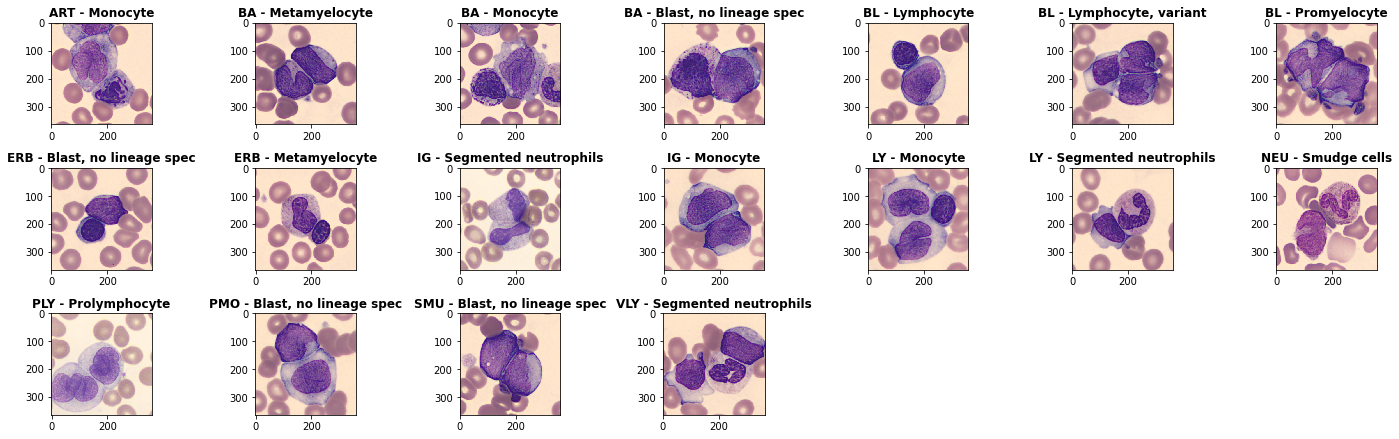

In [183]:
fig = plt.figure(figsize = (20,10))

for i, indices in enumerate(label_count[label_count['count']<2].index):
    label, celltype = indices
    plt.subplot(5, 7, i+1)
    io.imshow(df[(df['label'] == label) & (df['cell_type'] == celltype)]['img_paths'].item())
    plt.title(f'{label} - {celltype}', fontweight='bold')

In [192]:
label_count[label_count['count'].between(2, 20)]

count
label   cell_type                    
BL      Monocyte                    2
MO      Blast, no lineage spec      3
        Lymphocyte                  3
NEU     Lymphocyte                  2
        Blast, no lineage spec      3
PMO     Promyelocyte               20
USRWBC2 Young Unidentified          7

In [202]:
@interact(label = df.label.unique(), celltype= df.cell_type.unique())
def show_im(label, celltype):
    temp_df = df[(signed.label==label) & (df.cell_type == celltype)]
    img = leuko.load_image(np.random.choice(temp_df["img_paths"]))
    return io.imshow(img)

interactive(children=(Dropdown(description='label', options=('ERB', 'VLY', 'NEU', 'IG', 'MO', 'SMU', 'LY', 'BL…

In [201]:
label_count[label_count['count']<5].sum()/df.shape[0] *100

count    0.1984
dtype: float64

### Conclusion
Most of the cell that are badly classified show 2 cells. We will exclude those values for now (0.2% of total dataset).

In [220]:
for i, indices in enumerate(label_count[label_count['count']<5].index):
    label, celltype = indices
    df = df.drop(df[(df['label'] == label) & (df['cell_type'] == celltype)].index)


In [222]:
label_count = pd.DataFrame(df[['label', 'cell_type']].value_counts()).sort_values('label').rename(columns={0:'count'})
label_count

count
label   cell_type                     
ART     Arifact                     25
BA      Basophil                    53
BL      Blast, no lineage spec    3297
EO      Eosinophils                108
ERB     Erythroblast               521
ERC     Thrombocyte aggregation     22
GT      Giant thrombocyte           66
IG      Promyelocyte               667
        Myelocyte                  181
        Metamyelocyte               76
LY      Lymphocyte                3428
MO      Monocyte                  1313
NEU     Band neutrophils           171
        Segmented neutrophils     2089
PC      Plasma cells                58
PMO     Promonocyte                 71
        Promyelocyte                20
SMU     Smudge cells              2927
UI      Unidentified                24
USRWBC2 Young Unidentified           7
VLY     Lymphocyte, variant        470

### Others
UI, USRWBC2,ART
These cells are difficult to classify as such and the unidentified and young unidentified are obscure. We could keep those cells for testing.

### Lymphocytes

Cancer tends to trigger lymphocytosis and thus the appearance of divergent morphologic lymphocytes:
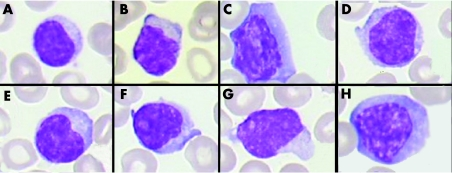

(A) lymphocyte with >90% accordance; (B) normal or atypical; (C) normal or plasma cell; (D) normal, atypical or prolymphocyte; (E) normal, atypical or plasma cell; (F) normal, atypical, prolymphocyte or plasma cell; (G) normal, atypical, prolymphocyte or blast; (H) normal, atypical, prolymphocyte, plasma cell or blast.

<font size="2"> <span style="color:grey"> Ref: The divergent morphological classification of variant lymphocytes in blood smears. W. van der Meer, J Clin Pathol. 2007  </span> </font>

In [204]:
def plot_rand_class(label, df):
     
    temp_df =  df[df.label.isin(label)]

    display(temp_df.head())
    rand = np.random.choice(temp_df.index.to_numpy(), size = 18)
    
    fig, axes = plt.subplots(3, 6, figsize=(20, 12))

    for ax, idx in zip(axes.flatten(), rand):
        
        img = leuko.load_image(df.iloc[idx]['img_paths'])
        
        ax.imshow(img)
        lab = df.loc[idx]['label']
        ax.set_title(f'{idx} - {lab}', fontweight='bold')
      
    return fig 

,img_paths,id,label,cell_type,patient
32,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828445,VLY,"Lymphocyte, variant",PBC_dataset_APL_AML
33,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828407,VLY,"Lymphocyte, variant",PBC_dataset_APL_AML
34,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828464,VLY,"Lymphocyte, variant",PBC_dataset_APL_AML
35,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828483,VLY,"Lymphocyte, variant",PBC_dataset_APL_AML
36,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828496,VLY,"Lymphocyte, variant",PBC_dataset_APL_AML


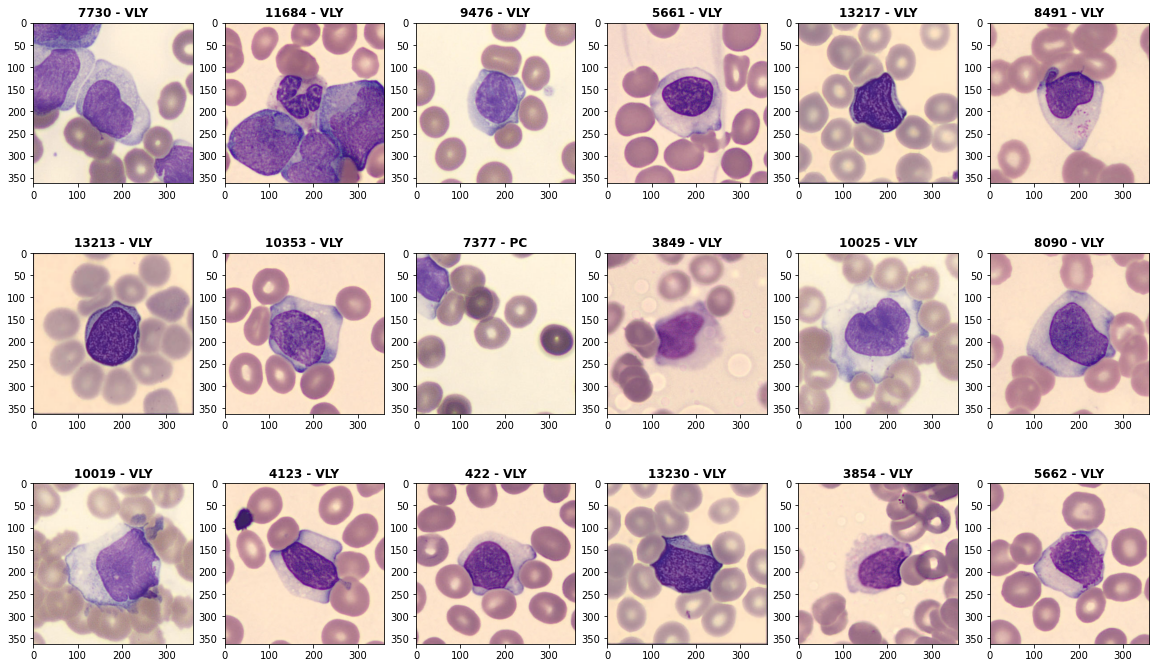

In [210]:
plot_rand_class(['PC', 'PLY', 'VLY'], signed);

In [7]:


#Fusion of lymphocyte sub-groups
signed["label"] = signed["label"].replace(to_replace = ["VLY", "PLY"], # PLY = precusor lymphocyte
                                  value = ["LY", "LY"])

#Fusion of monocyte sub-groups
signed["label"] = signed["label"].replace(to_replace = ["PMO"], 
                                  value = ["MO"])

In [196]:
label_count[label_count['count']>3]

count
label   cell_type                     
ART     Arifact                     25
BA      Basophil                    53
BL      Blast, no lineage spec    3297
EO      Eosinophils                108
ERB     Erythroblast               521
ERC     Thrombocyte aggregation     22
GT      Giant thrombocyte           66
IG      Metamyelocyte               76
        Myelocyte                  181
        Promyelocyte               667
LY      Lymphocyte                3428
MO      Monocyte                  1313
NEU     Segmented neutrophils     2089
        Band neutrophils           171
PC      Plasma cells                58
PMO     Promonocyte                 71
        Promyelocyte                20
SMU     Smudge cells              2927
UI      Unidentified                24
USRWBC2 Young Unidentified           7
VLY     Lymphocyte, variant        470

In [ ]:
def plot_on_grid_by_cell(label, outliers=False):
    temp_df =  df[df.label == label]
    display(temp_df.head())
        
    temp_images = images[temp_df.index]
    
    temp_df = temp_df.reset_index(drop=True)
    
    plot_on_grid(temp_images, temp_df)

    return fig

SyntaxError: invalid syntax (<ipython-input-5-6d1a26b1e239>, line 3)

In [6]:
test = pd.DataFrame(signed[['label', 'cell_type']].value_counts()).sort_values('label')
test

0
label   cell_type                    
ART     Monocyte                    1
        Arifact                    25
BA      Metamyelocyte               1
        Monocyte                    1
        Blast, no lineage spec      1
        Basophil                   53
BL      Blast, no lineage spec   3300
        Lymphocyte                  1
        Lymphocyte, variant         1
        Monocyte                    2
        Promyelocyte                1
BNE     Segmented neutrophils       2
        Band neutrophils          171
EO      Eosinophils               108
ERB     Metamyelocyte               1
        Blast, no lineage spec      1
        Erythroblast              521
ERC     Thrombocyte aggregation    22
GT      Giant thrombocyte          66
LY      Segmented neutrophils       1
        Monocyte                    1
        Lymphocyte               3429
MMY     Metamyelocyte              75
        Segmented neutrophils       1
        Promyelocyte                1
MO      Lymphocyte                  3
        Blast, no lineage spec      3
        Monocyte                 1313
MY      Metamyelocyte               1
        Myelocyte                 181
PC      Plasma cells               58
PLY     Prolymphocyte               1
PMO     Promyelocyte               20
        Promonocyte                71
        Blast, no lineage spec      1
PMY     Monocyte                    1
        Promyelocyte              666
SMU     Blast, no lineage spec      1
        Smudge cells             2930
SNE     Smudge cells                1
        Blast, no lineage spec      3
        Lymphocyte                  2
        Segmented neutrophils    2087
UI      Unidentified               24
USRWBC2 Young Unidentified          7
VLY     Lymphocyte, variant       470
        Segmented neutrophils       1

In [46]:
signed[['label', 'cell_type']].drop_duplicates().sort_values('label')

,label,cell_type
13009,ART,Monocyte
1983,ART,Arifact
6292,BA,Metamyelocyte
14461,BA,Monocyte
13127,BA,"Blast, no lineage spec"
664,BA,Basophil
3583,BL,Lymphocyte
1358,BL,Monocyte
925,BL,"Lymphocyte, variant"
198,BL,"Blast, no lineage spec"


In [8]:
signed.label.unique()

array(['ERB', 'LY', 'SNE', 'IG', 'MO', 'SMU', 'BL', 'PC', 'GT', 'UI',
       'EO', 'BA', 'ART', 'ERC', 'USRWBC2'], dtype=object)

In [24]:
signed[['label', 'cell_type']].drop_duplicates().sort_values('label')

,label,cell_type
1983,ART,Arifact
13009,ART,Monocyte
6292,BA,Metamyelocyte
13127,BA,"Blast, no lineage spec"
14461,BA,Monocyte
664,BA,Basophil
8122,BL,Promyelocyte
1358,BL,Monocyte
198,BL,"Blast, no lineage spec"
925,BL,"Lymphocyte, variant"


Some cells are classified as `unidentified` or `arifact` (Artifact) but look like blasts:  

Artifact 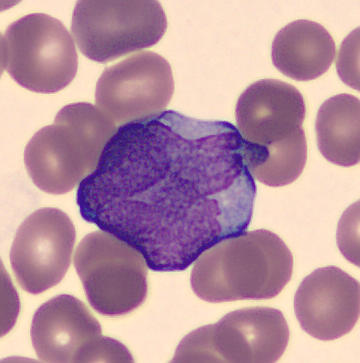 
Unidentified 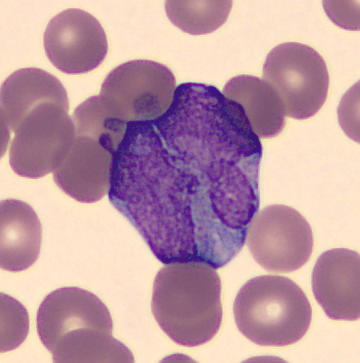 
Blast 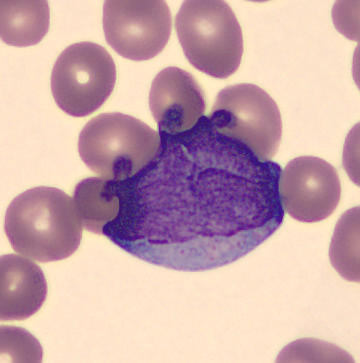

In [25]:
signed[(signed.label =='ERC')]#& (df.cell_type=='Blast, no lineage spec')]

,img_paths,id,label,cell_type,patient
5854,../../data/PBC_dataset_APL_AML/Patient_35/Sign...,13658405,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7411,../../data/PBC_dataset_APL_AML/Patient_103/Sig...,17763339,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7653,../../data/PBC_dataset_APL_AML/Patient_62/Sign...,13162326,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7654,../../data/PBC_dataset_APL_AML/Patient_62/Sign...,13162023,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7655,../../data/PBC_dataset_APL_AML/Patient_62/Sign...,13162438,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7656,../../data/PBC_dataset_APL_AML/Patient_62/Sign...,13161970,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7657,../../data/PBC_dataset_APL_AML/Patient_62/Sign...,13161963,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
8709,../../data/PBC_dataset_APL_AML/Patient_104/Sig...,25029618,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
8710,../../data/PBC_dataset_APL_AML/Patient_104/Sig...,25029619,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
8711,../../data/PBC_dataset_APL_AML/Patient_104/Sig...,25029617,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML


# TO DO clean up cell